# Fantasy football wide-receivers points prediction model using neural network

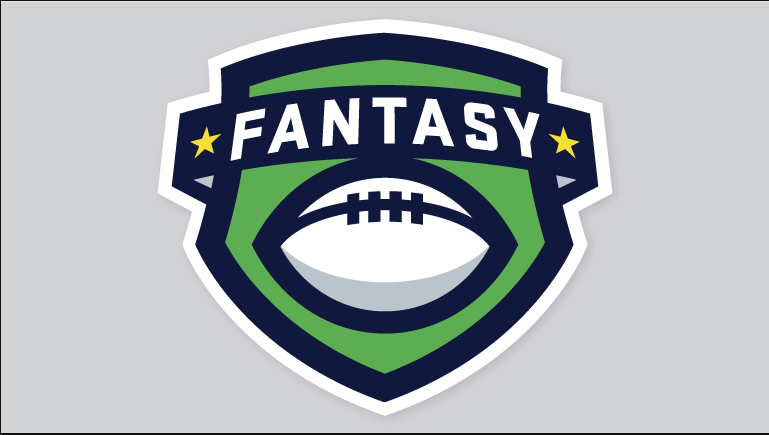


#### Goal of the project : Create a model that will predict the number of points NFL wide receiver should score in the upcoming 2022-2023 season.

#### How : Make use of the massive amount of readily available data on players/fantasy scoring within a neural network.

#### Framework :
    - Standard fantasy football points scoring system
    - Isolate wide-receiver scoring, but the model could very easily be re-used for other positions (RB, QB, TE)
    - Data is fetched from nfl_data_py API
    - Historical range of data used will be 20 years (2000-2020)
    - Use 2021 as the testing data to generate the 2022 predictions
    - Compare the end results to other fantasy football references (ESPN, FantasyPros)
##### Note that I will also be comparing the performance of my neural network against classical regression model

#### Presentation structure :
    - Introduction to fantasy football (quick I promise :D)
    - Pre-modeling : Fetching data from the API and cleaning
    - Understanding our data
    - The neural network
    - Prediction results
    - Neural network VS classical regression, which performs best?
    - Deployment + Demo
    - Conclusion

# A quick introduction to fantasy football


Fantasy football is extremely popular amongst nfl (amercian football) fans. Although many only play it for fun, it actually generates billions of dollars every season. https://www.statista.com/statistics/1175890/fantasy-sports-service-industry-market-size-us/#:~:text=The%20market%20size%20of%20the,increase%20over%20the%20previous%20year.

The goal of fantasy football is to build the best team possible from the pool of available players on a given season. Every week, you are playing against other managers and your team has to produce more points than the other to get the win. Points are generated based on the performance of players on that specific week. There are multiple categories of players you need to choose from (RB, WR, QB, TE, K, D). I will be focusing on WR in this project.

Using readily available data, I want to create a model that will be able to predict how many fantasy points the best NFL wide receivers will be scoring next season. This model will then help me make my choices to build my 2022-2023 roster. 

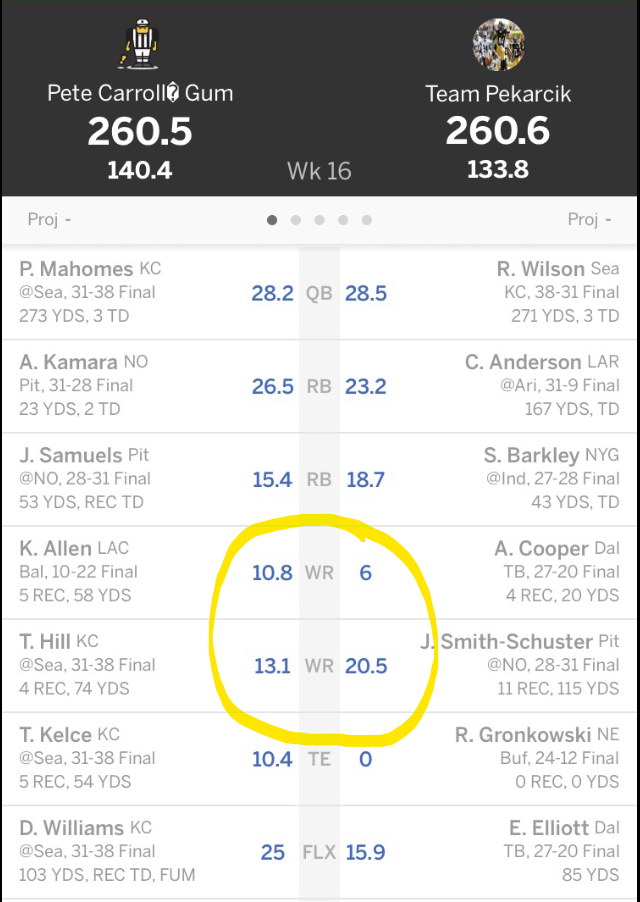

The below image shows the top 2021 WR performers. 

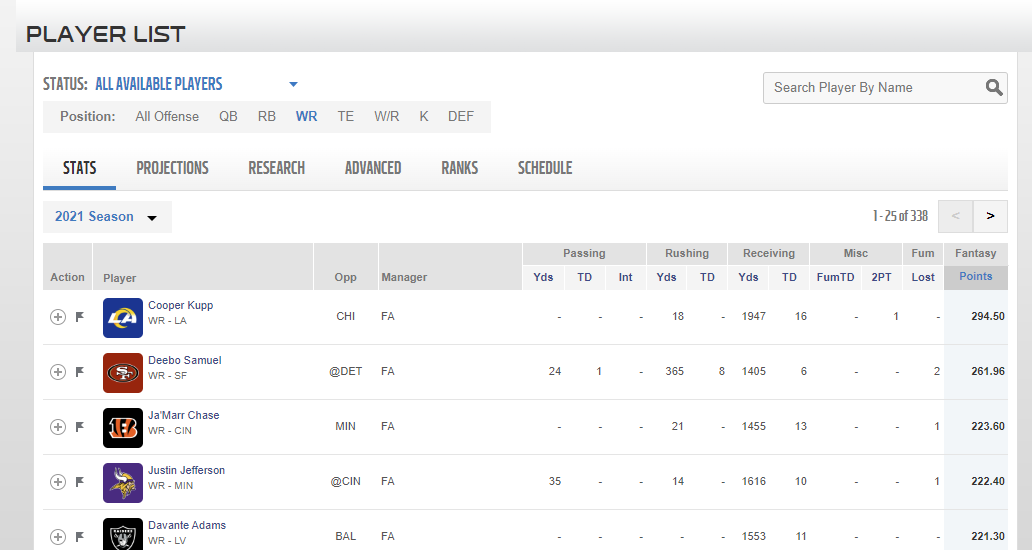

The scoring system is very simple and takes into accounts only a few data points. The way to predict player performance however, is much more complex. There are hundreds of features to choose from when getting into the analysis. Below is a list of them which I will experience with in my neural network.

- Number of targets per game
- Number of catches per game
- Average depth of targets
- Average yards after catch
- Numbers of games played
- Total number of yards/game
- Player age
- Carries
- Touchdown passes caught
- Fumbles

I've reached out to the NFL directly to try and get access to their developer API to get the data but they charge a large annual fee.

https://developer.nfl.com/

I was thinking of scrapping the data directly from the web (plenty of available resources) but luckily there was an existing free API that got me what I needed.

https://pypi.org/project/nfl-data-py/

In [3]:
from datetime import datetime, date
import matplotlib.pyplot as plt
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import pickle
import os

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import  train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.losses import SparseCategoricalCrossentropy
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Pre-modeling : Getting the data and cleaning it

In [4]:
# Loading historical player stats and fantasy points per year

sea_l = [year for year in range(2000,2022)]
drop_l = ['season_type', 'interceptions', 'sacks', 'sack_yards','sack_fumbles', 'sack_fumbles_lost',
         'passing_first_downs', 'passing_epa', 'dakota', 'special_teams_tds', 'fantasy_points_ppr']

df = nfl.import_seasonal_data(sea_l)
df_stats = df[df['season_type'] == 'REG']
df_stats = df_stats.drop(columns=drop_l)
df_stats.head(5)

,player_id,season,completions,attempts,passing_yards,passing_tds,passing_air_yards,passing_yards_after_catch,passing_2pt_conversions,carries,...,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
0,00-0000003,2000,0,0,0.0,0,0.0,0.0,0,1,...,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002418
1,00-0000007,2000,0,0,0.0,0,0.0,0.0,0,16,...,NaN,NaN,0.034230,0.0,0.043478,0.041667,0.017115,0.027384,0.197183,0.053758
2,00-0000007,2001,0,0,0.0,0,0.0,0.0,0,11,...,NaN,NaN,0.064838,0.0,0.095238,0.083333,0.032419,0.051870,0.412698,0.054108
3,00-0000007,2003,0,0,0.0,0,0.0,0.0,0,18,...,NaN,NaN,0.024091,0.0,0.027273,0.025424,0.012046,0.019273,0.139241,0.021780
4,00-0000007,2004,0,0,0.0,0,0.0,0.0,0,13,...,NaN,NaN,0.007149,0.0,0.000000,0.000000,0.003574,0.005719,0.051136,0.018839


In [5]:
# Loading NFL historical rosters to be able to filter on WR and get players AGE which will be an important feature
# Some data cleaning needed to be done here as well. Notably missing DOB which caused issues on later transforms

df1 = nfl.import_rosters(sea_l)

df_players = pd.DataFrame()
df_players['player_id'] = df1['player_id']
df_players['birth_date'] = df1['birth_date']
df_players['position'] = df1['position']
df_players['name'] = df1['first_name'] + ' ' + df1['last_name']

df_players.drop_duplicates(subset ="player_id",keep = 'first', inplace = True)

# Some players DOB was missing everywhere "had to look it up on google"
df_players.loc[df_players.name == 'Brandon Marshall', 'birth_date'] = '1984-03-23'
df_players.loc[df_players.name == 'Brandon LaFell', 'birth_date'] = '1986-11-04'
df_players.loc[df_players.name == 'Eric Decker', 'birth_date'] = '1987-03-15'
df_players.loc[df_players.player_id == '00-0027793', 'birth_date'] = '1988-07-10'
df_players.loc[df_players.player_id == '00-0036900', 'birth_date'] = '2000-03-01'
df_players.loc[df_players.name == 'Dez Bryant', 'birth_date'] = '1988-11-04'
df_players.loc[df_players.name == 'Kelvin Benjamin', 'birth_date'] = '1991-02-05'
df_players.loc[df_players.name == 'Justin Jefferson', 'birth_date'] = '1999-01-16'
df_players.loc[df_players.name == 'Michael Crabtree', 'birth_date'] = '1987-09-14'
df_players.loc[df_players.name == 'Jaylen Waddle', 'birth_date'] = '1998-11-25'
df_players.loc[df_players.name == 'Elijah Moore', 'birth_date'] = '2000-03-27'
df_players.loc[df_players.name == 'Rashod Bateman', 'birth_date'] = '1999-11-29'
df_players.loc[df_players.name == 'Amon-Ra St. Brown', 'birth_date'] = '1999-10-24'
df_players.loc[df_players.name == 'DeVonta Smith', 'birth_date'] = '1998-11-14'
df_players.loc[df_players.name == 'Kadarius Toney', 'birth_date'] = '1999-01-27'

placeh = pd.to_datetime('1900-01-01')
df_players['birth_date'] = df_players['birth_date'].fillna(placeh)

df_players.tail(5)

,player_id,birth_date,position,name
3028,00-0036703,1999-03-05,SPEC,Brian Johnson
3036,00-0036474,1995-10-19,TE,Sammis Reyes
3037,00-0036628,1997-11-06,TE,John Bates
3046,00-0036626,1999-11-01,WR,Dyami Brown
3047,00-0036671,1999-06-23,WR,Dax Milne


In [6]:
# Merge the players and stats dataframe to get ALL the data required in one place. Filter on 'WR' only

df_full = pd.merge(df_stats,df_players,on = 'player_id',how='left')
df_wr_full = df_full[df_full.position == 'WR']
df_wr_full[df_wr_full['name'] == 'Antonio Brown']

,player_id,season,completions,attempts,passing_yards,passing_tds,passing_air_yards,passing_yards_after_catch,passing_2pt_conversions,carries,...,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh,birth_date,position,name
3834,00-0021425,2003,0,0,0.0,0,0.0,0.0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018731,1978-03-03,WR,Antonio Brown
3835,00-0021425,2005,0,0,0.0,0,0.0,0.0,0,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032196,1978-03-03,WR,Antonio Brown
7980,00-0027793,2010,0,0,0.0,0,0.0,0.0,0,0,...,0.000000,0.114943,0.104167,0.044439,0.071102,0.684426,0.060653,1988-07-10,WR,Antonio Brown
7981,00-0027793,2011,0,0,0.0,0,0.0,0.0,0,7,...,0.095238,0.257919,0.243802,0.175475,0.223617,2.055659,0.146738,1988-07-10,WR,Antonio Brown
7982,00-0027793,2012,0,2,0.0,0,41.0,0.0,0,7,...,0.192308,0.247126,0.240000,0.209981,0.220585,1.678038,0.147209,1988-07-10,WR,Antonio Brown
7983,00-0027793,2013,1,1,15.0,0,11.0,4.0,0,7,...,0.285714,0.338164,0.331915,0.316917,0.335638,2.558020,0.223074,1988-07-10,WR,Antonio Brown
7984,00-0027793,2014,2,2,20.0,1,9.0,11.0,0,4,...,0.393939,0.349794,0.355072,0.366872,0.350631,2.774510,0.233661,1988-07-10,WR,Antonio Brown
7985,00-0027793,2015,0,0,0.0,0,0.0,0.0,0,3,...,0.384615,0.405797,0.403433,0.382478,0.381195,3.108475,0.246840,1988-07-10,WR,Antonio Brown
7986,00-0027793,2016,0,0,0.0,0,0.0,0.0,0,3,...,0.400000,0.328205,0.337778,0.356585,0.330537,2.296959,0.211916,1988-07-10,WR,Antonio Brown
7987,00-0027793,2017,0,0,0.0,0,0.0,0.0,0,0,...,0.346154,0.362245,0.360360,0.361452,0.370632,2.876173,0.231126,1988-07-10,WR,Antonio Brown


In [7]:
# Still have some missing DOB, needed to get the info from another source

df_dob = pd.read_csv('C:/Users/phili/Onedrive/Desktop/players_dat.txt',header=1)
df_dob1 = df_dob[(df_dob['Rk'] != 'Rk') & (df_dob['Rk'].notnull())]
s1 = []

# Clean players name from the file
for i in df_dob1['Player']:
    s1.append(i.split('\\')[0].split('*')[0])
    
df_dob1['name'] = s1

df_dob2 = pd.DataFrame()
df_dob2['name'] = df_dob1['name']
df_dob2['season'] = df_dob1['Year']
df_dob2['age'] = df_dob1['Age']

df_dob2 = df_dob2.reset_index(drop=True)
df_dob2['season'] = df_dob2['season'].astype(str).astype(int)

df_dob2

,name,season,age
0,Jerry Rice,1987,25
1,Wes Chandler,1982,26
2,Jerry Rice,1995,33
3,Randy Moss,2007,30
4,Anthony Allen,1987,28
...,...,...,...
6456,Devon Wylie,2014,26
6457,Milton Wynn,2002,24
6458,Craig Yeast,2001,25
6459,Mike Young,1994,32


In [8]:
# Data cleaning continues
# One source had the player age, the other the DOB. Create a function to extract the player age from current SEASON and
# DOB.

def age(old,new):
    old = old
    new = new
    return -(new.year - old.year - ((new.month, new.day) < (old.month,old.day)))

df_conv = pd.merge(df_wr_full,df_dob2,on=['name','season'],how='left')
df_conv = df_conv.drop_duplicates(subset=['player_id','season'])
df_conv['season'] = pd.to_datetime(df_conv['season'], format='%Y')

true_age = []   

for row in df_conv.iterrows():
    true_age.append(age(row[1][1],row[1][47]))

df_conv['age2'] = true_age
df_wr = df_conv

final_l = []

for row in df_wr.iterrows():
    if row[1][51] > 80:
        final_l.append(row[1][50])
    else:
        final_l.append(row[1][51])
        
# More data cleaning
        
df_wr['fin'] = final_l
df_wr['age'] = df_wr['fin']
df_wr = df_wr.drop(columns=['age2','fin','birth_date'])
df_wr = df_wr[df_wr['age'].notna()]
df_wr = df_wr.reset_index(drop=True)
df_wr['season'] = df_wr['season'].dt.year.astype(str).astype(int)
df_wr['age'] = df_wr['age'].astype(str).astype(int)
df_wr.replace([np.inf, -np.inf], np.nan, inplace=True)
df_wr = df_wr.fillna(0)

# Historical data distribution

### Distribution of individual players points per seasons

Text(0, 0.5, 'Fantasy Points')

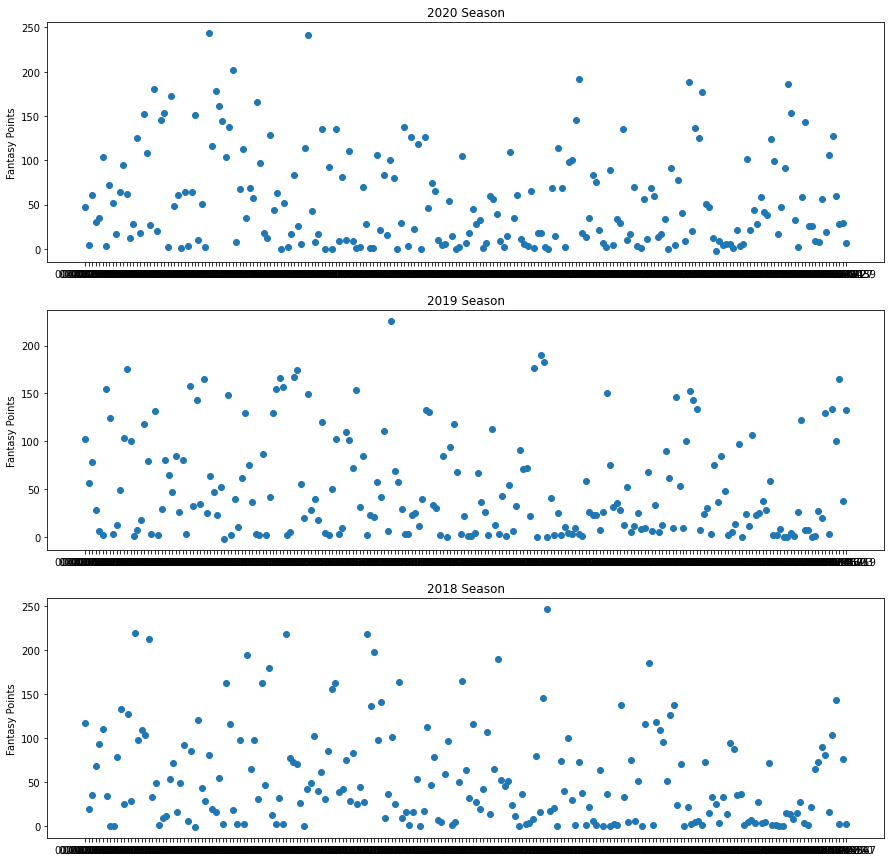

In [9]:
x4 = df_wr[df_wr['season'] == 2020]['player_id']
y4 = df_wr[df_wr['season'] == 2020]['fantasy_points']

x5 = df_wr[df_wr['season'] == 2019]['player_id']
y5 = df_wr[df_wr['season'] == 2019]['fantasy_points']

x6 = df_wr[df_wr['season'] == 2018]['player_id']
y6 = df_wr[df_wr['season'] == 2018]['fantasy_points']

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].scatter(x4,y4)
ax[0].set_ylabel('Fantasy Points')
ax[0].title.set_text('2020 Season')
ax[1].scatter(x5,y5)
ax[1].set_ylabel('Fantasy Points')
ax[1].title.set_text('2019 Season')
ax[2].scatter(x6,y6)
ax[2].title.set_text('2018 Season')
ax[2].set_ylabel('Fantasy Points')

### Number of players per points brackets in a given year

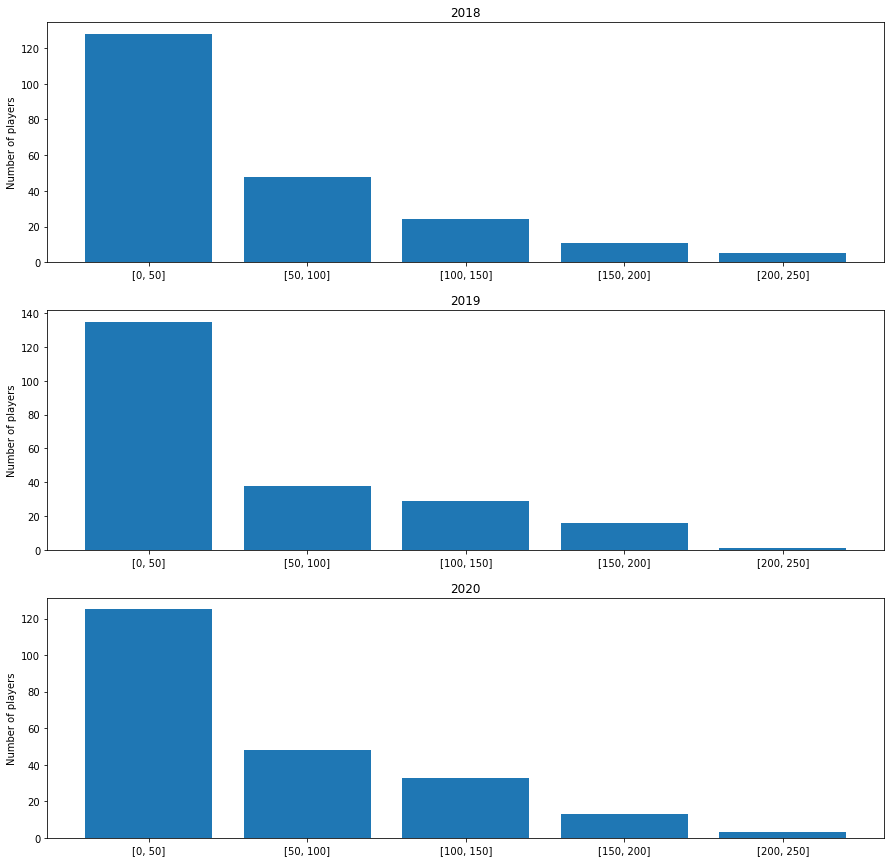

In [10]:
y2018 = {}
y2019 = {}
y2020 = {}

for i in [2018,2019,2020]:
    for j in [[0,50],[50,100],[100,150],[150,200],[200,250]]:
        if i == 2018:
            y2018[str(j)] = len(df_wr[(df_wr['season'] == i) & (df_wr['fantasy_points'] >= j[0]) &
                            (df_wr['fantasy_points'] < j[1])]['fantasy_points'])
        if i == 2019:
            y2019[str(j)] = len(df_wr[(df_wr['season'] == i) & (df_wr['fantasy_points'] >= j[0]) &
                            (df_wr['fantasy_points'] < j[1])]['fantasy_points'])

        if i == 2020:
            y2020[str(j)] = len(df_wr[(df_wr['season'] == i) & (df_wr['fantasy_points'] >= j[0]) &
                            (df_wr['fantasy_points'] < j[1])]['fantasy_points'])
            
x2018 = pd.DataFrame.from_dict(y2018, orient='index')
x2019 = pd.DataFrame.from_dict(y2019, orient='index')
x2020 = pd.DataFrame.from_dict(y2020, orient='index')

x7 = np.array(x2018.index)
y7 = x2018[0]

x8 = np.array(x2019.index)
y8 = x2019[0]

x9 = np.array(x2020.index)
y9 = x2020[0]

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].bar(x7,y7)
ax[0].set_ylabel('Number of players')
ax[0].title.set_text('2018')
ax[1].bar(x8,y8)
ax[1].set_ylabel('Number of players')
ax[1].title.set_text('2019')
ax[2].bar(x9,y9)
ax[2].set_ylabel('Number of players')
ax[2].title.set_text('2020')

### Display of fantasy points (dependent var) per year and how it swings even for good players

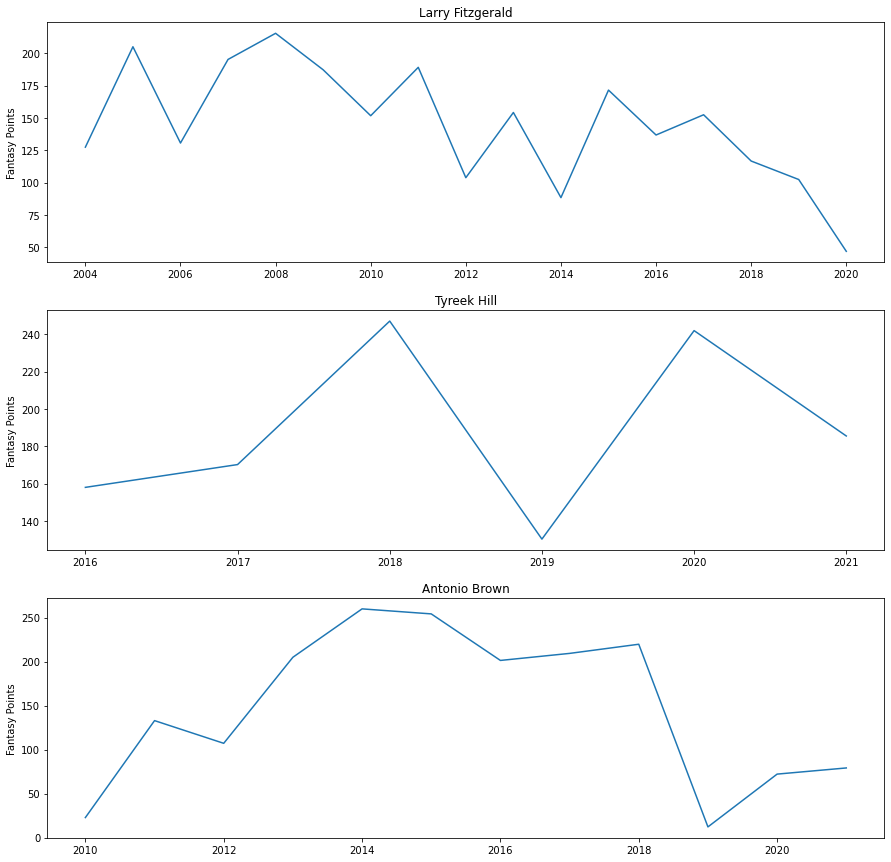

In [11]:
x1 = df_wr[df_wr['name'] == 'Larry Fitzgerald']['season']
y1 = df_wr[df_wr['name'] == 'Larry Fitzgerald']['fantasy_points']

x2 = df_wr[df_wr['name'] == 'Tyreek Hill']['season']
y2 = df_wr[df_wr['name'] == 'Tyreek Hill']['fantasy_points']

x3 = df_wr[df_wr['player_id'] == '00-0027793']['season'] # Antonio Brown
y3 = df_wr[df_wr['player_id'] == '00-0027793']['fantasy_points']

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(x1,y1)
ax[0].set_ylabel('Fantasy Points')
ax[0].title.set_text('Larry Fitzgerald')
ax[1].plot(x2,y2)
ax[1].set_ylabel('Fantasy Points')
ax[1].title.set_text('Tyreek Hill')
ax[2].plot(x3,y3)
ax[2].title.set_text('Antonio Brown')
ax[2].set_ylabel('Fantasy Points')

plt.show()

In [155]:
# Just saving my raw data in case something goes wrong with the API while i'm experimenting with my project

df_wr.to_csv("C:/Users/phili/OneDrive/Desktop/df_wr.txt")
df_wr_full.to_csv("C:/Users/phili/OneDrive/Desktop/df_wr_full.txt")

# The neural network

### Complete list of features to predict player performance

In [12]:
for i in df_wr.columns:
    print(i)

player_id
season
completions
attempts
passing_yards
passing_tds
passing_air_yards
passing_yards_after_catch
passing_2pt_conversions
carries
rushing_yards
rushing_tds
rushing_fumbles
rushing_fumbles_lost
rushing_first_downs
rushing_epa
rushing_2pt_conversions
receptions
targets
receiving_yards
receiving_tds
receiving_fumbles
receiving_fumbles_lost
receiving_air_yards
receiving_yards_after_catch
receiving_first_downs
receiving_epa
receiving_2pt_conversions
fantasy_points
pacr
racr
target_share
air_yards_share
wopr_x
games
tgt_sh
ay_sh
yac_sh
wopr_y
ry_sh
rtd_sh
rfd_sh
rtdfd_sh
dom
w8dom
yptmpa
ppr_sh
position
name
age


In [13]:
# Excluding 2021 data points from X, these are our validation/prediction data points.

X = df_wr[df_wr['season'] != 2021]
y = X['fantasy_points']
X = X.drop(columns=['player_id','position','name','fantasy_points'])

# Tried removing more features when running the neural net to see if it would affect it's performance/accuracy

# X = X.drop(columns=['player_id','position','name','fantasy_points',
#                    'completions', 'attempts', 'passing_yards',
#                    'passing_tds', 'passing_air_yards', 'passing_yards_after_catch',
#                    'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds',
#                    'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs',
#                    'rushing_epa', 'rushing_2pt_conversions'])

# Using sklearn StandardScaler function to standardise our data. We have a large amount of features, each of which 
# are on different scales. Results would not make any sense if we didn't standaradize the input.

X = StandardScaler().fit_transform(X)

# I played with test size during the experimental phases, 0.25 seemed like a good ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Training data length: {len(X_train)}")

print(f"Testing data shape: {X_test.shape}")
print(f"Testing data length: {len(X_test)}")

Training data shape: (2949, 46)
Training data length: 2949
Testing data shape: (984, 46)
Testing data length: 984


## Model details

The next few cells will show the configuration of the neural network as well as the training and the results I've achieved. A lot of iterations were tried to find the best possible configuration for the model. Some parameters I've played with include :
#### - Kernel initializer 
    - Used to define to way to set the initial random weights of Keras layers.
#### - Activation function for input, dense and output layers 
    - Played with RELU, SELU, SOFTMAX
#### - Batch normalization
    - Tried using it between layers to normalize the input to the activation function, didn't help.
#### - Loss functions
    - Overwhelming recommandation on using 'MSE' as loss function for regression problems but also tested 'MAE'
#### - Optimizers
    - Adam, SGD, AdaDelta. Adam performed better
#### - Dropouts
    - Prevent the overfitting. Fraction of the input units to drop during training
#### - Learning rate (model.optimizer.learning_rate)
    - Default, 0.0001, 0.005
#### - Number of features used
    - 20,30,46
#### - Number of dense layers/ units (neurons)
    - More isn't necessarely better.
#### - Adjust training/test size
    - Usually input volume matters a lot in training

I've even tried to convert my input into a 46x46x1 matrix to use Conv2D layers, it didnt' yield better accuracy in the end.

In [14]:
# The model
model = tf.keras.Sequential()
model.add(Dense(28, input_shape=(46,), kernel_initializer='normal',activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae","mse"])

In [16]:
from keras import backend as K

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28)                1316      
                                                                 
 dense_1 (Dense)             (None, 64)                1856      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 6

### Running the model

In [17]:
# es = EarlyStopping(monitor='val_loss', patience=200) -- I tried using early stopping but it was unecessary, didn't help with
# the accuracy of the results

K.set_value(model.optimizer.learning_rate, 0.001) #0.001 = DEFAULT ()
epochs = 1000
history = model.fit(X_train, y_train, batch_size=10, validation_split=0.1, epochs=epochs)

Epoch 1/1000
266/266 [==============================] - 1s 1ms/step - loss: 1173.9183 - mae: 20.8538 - mse: 1173.9183 - val_loss: 70.6111 - val_mae: 6.1261 - val_mse: 70.6111
Epoch 2/1000
266/266 [==============================] - 0s 772us/step - loss: 282.8291 - mae: 10.7134 - mse: 282.8291 - val_loss: 96.4903 - val_mae: 6.3537 - val_mse: 96.4903
Epoch 3/1000
266/266 [==============================] - 0s 783us/step - loss: 302.5529 - mae: 10.8420 - mse: 302.5529 - val_loss: 104.0826 - val_mae: 6.3872 - val_mse: 104.0826
Epoch 4/1000
266/266 [==============================] - 0s 772us/step - loss: 321.8348 - mae: 10.7525 - mse: 321.8348 - val_loss: 32.0108 - val_mae: 3.9440 - val_mse: 32.0108
Epoch 5/1000
266/266 [==============================] - 0s 760us/step - loss: 262.6714 - mae: 10.0708 - mse: 262.6714 - val_loss: 54.3393 - val_mae: 4.8062 - val_mse: 54.3393
Epoch 6/1000
266/266 [==============================] - 0s 755us/step - loss: 267.9925 - mae: 10.0072 - mse: 267.9925 - val

Epoch 48/1000
266/266 [==============================] - 0s 753us/step - loss: 238.0482 - mae: 9.0230 - mse: 238.0482 - val_loss: 16.2602 - val_mae: 2.6979 - val_mse: 16.2602
Epoch 49/1000
266/266 [==============================] - 0s 772us/step - loss: 228.6492 - mae: 8.8333 - mse: 228.6491 - val_loss: 43.1512 - val_mae: 4.6307 - val_mse: 43.1512
Epoch 50/1000
266/266 [==============================] - 0s 768us/step - loss: 241.3416 - mae: 8.8686 - mse: 241.3416 - val_loss: 16.0061 - val_mae: 2.5854 - val_mse: 16.0061
Epoch 51/1000
266/266 [==============================] - 0s 777us/step - loss: 225.9531 - mae: 8.7530 - mse: 225.9531 - val_loss: 13.1790 - val_mae: 2.5478 - val_mse: 13.1790
Epoch 52/1000
266/266 [==============================] - 0s 770us/step - loss: 223.7864 - mae: 8.7623 - mse: 223.7864 - val_loss: 12.8253 - val_mae: 2.2407 - val_mse: 12.8253
Epoch 53/1000
266/266 [==============================] - 0s 751us/step - loss: 218.7230 - mae: 8.6831 - mse: 218.7230 - val_l

Epoch 95/1000
266/266 [==============================] - 0s 918us/step - loss: 207.2885 - mae: 8.2562 - mse: 207.2885 - val_loss: 9.1306 - val_mae: 2.0551 - val_mse: 9.1306
Epoch 96/1000
266/266 [==============================] - 0s 820us/step - loss: 199.7559 - mae: 8.2903 - mse: 199.7559 - val_loss: 12.7074 - val_mae: 2.1225 - val_mse: 12.7074
Epoch 97/1000
266/266 [==============================] - 0s 756us/step - loss: 215.1966 - mae: 8.3825 - mse: 215.1966 - val_loss: 18.7436 - val_mae: 2.6867 - val_mse: 18.7436
Epoch 98/1000
266/266 [==============================] - 0s 753us/step - loss: 229.2369 - mae: 8.6196 - mse: 229.2369 - val_loss: 18.4620 - val_mae: 2.0352 - val_mse: 18.4620
Epoch 99/1000
266/266 [==============================] - 0s 766us/step - loss: 209.1183 - mae: 8.3301 - mse: 209.1183 - val_loss: 22.3808 - val_mae: 3.0841 - val_mse: 22.3808
Epoch 100/1000
266/266 [==============================] - 0s 737us/step - loss: 203.8656 - mae: 8.2714 - mse: 203.8656 - val_lo

Epoch 142/1000
266/266 [==============================] - 0s 741us/step - loss: 196.5880 - mae: 7.9331 - mse: 196.5880 - val_loss: 17.5593 - val_mae: 2.3493 - val_mse: 17.5593
Epoch 143/1000
266/266 [==============================] - 0s 733us/step - loss: 181.8633 - mae: 7.8244 - mse: 181.8633 - val_loss: 30.2151 - val_mae: 3.5629 - val_mse: 30.2151
Epoch 144/1000
266/266 [==============================] - 0s 741us/step - loss: 182.4170 - mae: 7.8511 - mse: 182.4170 - val_loss: 7.4315 - val_mae: 1.8489 - val_mse: 7.4315
Epoch 145/1000
266/266 [==============================] - 0s 745us/step - loss: 184.0182 - mae: 7.8505 - mse: 184.0182 - val_loss: 42.3733 - val_mae: 4.4772 - val_mse: 42.3733
Epoch 146/1000
266/266 [==============================] - 0s 741us/step - loss: 198.6258 - mae: 8.2208 - mse: 198.6258 - val_loss: 28.7869 - val_mae: 3.3550 - val_mse: 28.7869
Epoch 147/1000
266/266 [==============================] - 0s 741us/step - loss: 184.1027 - mae: 8.0186 - mse: 184.1027 - v

Epoch 189/1000
266/266 [==============================] - 0s 793us/step - loss: 171.4583 - mae: 7.4784 - mse: 171.4583 - val_loss: 69.6203 - val_mae: 5.1531 - val_mse: 69.6203
Epoch 190/1000
266/266 [==============================] - 0s 779us/step - loss: 189.6289 - mae: 7.9749 - mse: 189.6289 - val_loss: 16.3945 - val_mae: 2.6980 - val_mse: 16.3945
Epoch 191/1000
266/266 [==============================] - 0s 772us/step - loss: 181.6675 - mae: 7.8418 - mse: 181.6675 - val_loss: 13.7464 - val_mae: 2.5166 - val_mse: 13.7464
Epoch 192/1000
266/266 [==============================] - 0s 753us/step - loss: 180.3322 - mae: 7.6321 - mse: 180.3322 - val_loss: 10.6440 - val_mae: 2.4973 - val_mse: 10.6440
Epoch 193/1000
266/266 [==============================] - 0s 770us/step - loss: 177.1080 - mae: 7.6856 - mse: 177.1080 - val_loss: 6.7780 - val_mae: 1.8670 - val_mse: 6.7780
Epoch 194/1000
266/266 [==============================] - 0s 798us/step - loss: 175.5627 - mae: 7.6216 - mse: 175.5627 - v

Epoch 236/1000
266/266 [==============================] - 0s 830us/step - loss: 173.6088 - mae: 7.4756 - mse: 173.6088 - val_loss: 10.4661 - val_mae: 2.0529 - val_mse: 10.4661
Epoch 237/1000
266/266 [==============================] - 0s 764us/step - loss: 173.4122 - mae: 7.7034 - mse: 173.4122 - val_loss: 9.5614 - val_mae: 1.9466 - val_mse: 9.5614
Epoch 238/1000
266/266 [==============================] - 0s 824us/step - loss: 183.8744 - mae: 7.7362 - mse: 183.8744 - val_loss: 6.0784 - val_mae: 1.5921 - val_mse: 6.0784
Epoch 239/1000
266/266 [==============================] - 0s 817us/step - loss: 168.5874 - mae: 7.5054 - mse: 168.5874 - val_loss: 8.2554 - val_mae: 2.0062 - val_mse: 8.2554
Epoch 240/1000
266/266 [==============================] - 0s 766us/step - loss: 162.8017 - mae: 7.2984 - mse: 162.8017 - val_loss: 6.9347 - val_mae: 1.5498 - val_mse: 6.9347
Epoch 241/1000
266/266 [==============================] - 0s 802us/step - loss: 173.1706 - mae: 7.4736 - mse: 173.1706 - val_los

Epoch 283/1000
266/266 [==============================] - 0s 775us/step - loss: 152.4598 - mae: 7.2600 - mse: 152.4598 - val_loss: 13.3105 - val_mae: 2.5776 - val_mse: 13.3105
Epoch 284/1000
266/266 [==============================] - 0s 749us/step - loss: 172.4240 - mae: 7.4655 - mse: 172.4240 - val_loss: 13.0705 - val_mae: 2.6249 - val_mse: 13.0705
Epoch 285/1000
266/266 [==============================] - 0s 779us/step - loss: 149.2435 - mae: 7.1758 - mse: 149.2435 - val_loss: 9.8721 - val_mae: 2.4188 - val_mse: 9.8721
Epoch 286/1000
266/266 [==============================] - 0s 756us/step - loss: 161.4618 - mae: 7.2891 - mse: 161.4618 - val_loss: 6.1575 - val_mae: 1.5072 - val_mse: 6.1576
Epoch 287/1000
266/266 [==============================] - 0s 756us/step - loss: 160.3693 - mae: 7.3804 - mse: 160.3693 - val_loss: 13.1163 - val_mae: 2.5275 - val_mse: 13.1163
Epoch 288/1000
266/266 [==============================] - 0s 819us/step - loss: 146.2521 - mae: 7.1159 - mse: 146.2521 - val

Epoch 330/1000
266/266 [==============================] - 0s 764us/step - loss: 170.2086 - mae: 7.3921 - mse: 170.2086 - val_loss: 16.0534 - val_mae: 2.7597 - val_mse: 16.0534
Epoch 331/1000
266/266 [==============================] - 0s 751us/step - loss: 141.9548 - mae: 7.2029 - mse: 141.9548 - val_loss: 10.9689 - val_mae: 2.5268 - val_mse: 10.9689
Epoch 332/1000
266/266 [==============================] - 0s 790us/step - loss: 162.8285 - mae: 7.4994 - mse: 162.8285 - val_loss: 14.3305 - val_mae: 2.6021 - val_mse: 14.3305
Epoch 333/1000
266/266 [==============================] - 0s 851us/step - loss: 171.2251 - mae: 7.6635 - mse: 171.2251 - val_loss: 45.9465 - val_mae: 4.0193 - val_mse: 45.9465
Epoch 334/1000
266/266 [==============================] - 0s 892us/step - loss: 141.5162 - mae: 7.1678 - mse: 141.5162 - val_loss: 9.9399 - val_mae: 2.2974 - val_mse: 9.9399
Epoch 335/1000
266/266 [==============================] - 0s 892us/step - loss: 160.0575 - mae: 7.2886 - mse: 160.0575 - v

Epoch 377/1000
266/266 [==============================] - 0s 790us/step - loss: 148.8713 - mae: 7.2594 - mse: 148.8713 - val_loss: 6.7841 - val_mae: 1.7122 - val_mse: 6.7841
Epoch 378/1000
266/266 [==============================] - 0s 797us/step - loss: 148.0178 - mae: 7.1864 - mse: 148.0178 - val_loss: 29.6729 - val_mae: 3.4468 - val_mse: 29.6729
Epoch 379/1000
266/266 [==============================] - 0s 815us/step - loss: 154.2366 - mae: 7.3133 - mse: 154.2366 - val_loss: 12.0777 - val_mae: 2.4329 - val_mse: 12.0777
Epoch 380/1000
266/266 [==============================] - 0s 819us/step - loss: 156.7847 - mae: 7.2940 - mse: 156.7847 - val_loss: 10.8017 - val_mae: 1.6130 - val_mse: 10.8017
Epoch 381/1000
266/266 [==============================] - 0s 792us/step - loss: 149.7792 - mae: 7.2219 - mse: 149.7792 - val_loss: 7.8805 - val_mae: 1.7627 - val_mse: 7.8805
Epoch 382/1000
266/266 [==============================] - 0s 806us/step - loss: 140.2688 - mae: 7.1361 - mse: 140.2688 - val

Epoch 424/1000
266/266 [==============================] - 0s 774us/step - loss: 146.7596 - mae: 7.3212 - mse: 146.7596 - val_loss: 12.1747 - val_mae: 2.5724 - val_mse: 12.1747
Epoch 425/1000
266/266 [==============================] - 0s 755us/step - loss: 134.3251 - mae: 7.0820 - mse: 134.3251 - val_loss: 12.8539 - val_mae: 2.0428 - val_mse: 12.8539
Epoch 426/1000
266/266 [==============================] - 0s 740us/step - loss: 148.1451 - mae: 7.3096 - mse: 148.1451 - val_loss: 18.9719 - val_mae: 2.7062 - val_mse: 18.9719
Epoch 427/1000
266/266 [==============================] - 0s 742us/step - loss: 144.9529 - mae: 7.2487 - mse: 144.9528 - val_loss: 8.4656 - val_mae: 1.9715 - val_mse: 8.4656
Epoch 428/1000
266/266 [==============================] - 0s 749us/step - loss: 143.5552 - mae: 7.2186 - mse: 143.5552 - val_loss: 7.4699 - val_mae: 2.0903 - val_mse: 7.4699
Epoch 429/1000
266/266 [==============================] - 0s 741us/step - loss: 143.8553 - mae: 7.1613 - mse: 143.8553 - val

Epoch 471/1000
266/266 [==============================] - 0s 745us/step - loss: 142.7974 - mae: 7.3794 - mse: 142.7974 - val_loss: 5.4072 - val_mae: 1.5125 - val_mse: 5.4072
Epoch 472/1000
266/266 [==============================] - 0s 749us/step - loss: 140.5546 - mae: 7.2239 - mse: 140.5547 - val_loss: 9.2086 - val_mae: 1.8730 - val_mse: 9.2086
Epoch 473/1000
266/266 [==============================] - 0s 741us/step - loss: 137.7021 - mae: 6.9780 - mse: 137.7021 - val_loss: 7.3140 - val_mae: 1.9316 - val_mse: 7.3140
Epoch 474/1000
266/266 [==============================] - 0s 734us/step - loss: 143.2846 - mae: 7.2370 - mse: 143.2846 - val_loss: 10.6338 - val_mae: 2.3062 - val_mse: 10.6338
Epoch 475/1000
266/266 [==============================] - 0s 738us/step - loss: 139.5110 - mae: 7.1943 - mse: 139.5110 - val_loss: 6.5614 - val_mae: 1.7598 - val_mse: 6.5614
Epoch 476/1000
266/266 [==============================] - 0s 753us/step - loss: 139.1752 - mae: 7.2473 - mse: 139.1752 - val_los

Epoch 518/1000
266/266 [==============================] - 0s 741us/step - loss: 135.5332 - mae: 7.1631 - mse: 135.5332 - val_loss: 7.8758 - val_mae: 2.1303 - val_mse: 7.8758
Epoch 519/1000
266/266 [==============================] - 0s 734us/step - loss: 120.9267 - mae: 6.9362 - mse: 120.9267 - val_loss: 7.6635 - val_mae: 1.7234 - val_mse: 7.6635
Epoch 520/1000
266/266 [==============================] - 0s 741us/step - loss: 132.2534 - mae: 7.0186 - mse: 132.2534 - val_loss: 16.9307 - val_mae: 2.8990 - val_mse: 16.9307
Epoch 521/1000
266/266 [==============================] - 0s 745us/step - loss: 123.1838 - mae: 6.8739 - mse: 123.1838 - val_loss: 7.4344 - val_mae: 1.8461 - val_mse: 7.4344
Epoch 522/1000
266/266 [==============================] - 0s 823us/step - loss: 140.2255 - mae: 7.1679 - mse: 140.2255 - val_loss: 10.1956 - val_mae: 2.3534 - val_mse: 10.1956
Epoch 523/1000
266/266 [==============================] - 0s 911us/step - loss: 130.4786 - mae: 6.9871 - mse: 130.4786 - val_l

Epoch 565/1000
266/266 [==============================] - 0s 794us/step - loss: 120.5936 - mae: 6.9976 - mse: 120.5936 - val_loss: 28.3669 - val_mae: 3.2725 - val_mse: 28.3669
Epoch 566/1000
266/266 [==============================] - 0s 782us/step - loss: 132.7540 - mae: 7.1601 - mse: 132.7540 - val_loss: 14.3205 - val_mae: 2.6984 - val_mse: 14.3205
Epoch 567/1000
266/266 [==============================] - 0s 802us/step - loss: 127.6071 - mae: 7.0289 - mse: 127.6071 - val_loss: 10.7307 - val_mae: 2.4574 - val_mse: 10.7307
Epoch 568/1000
266/266 [==============================] - 0s 768us/step - loss: 119.1909 - mae: 6.8745 - mse: 119.1909 - val_loss: 10.9586 - val_mae: 2.3698 - val_mse: 10.9586
Epoch 569/1000
266/266 [==============================] - 0s 756us/step - loss: 119.5674 - mae: 6.8351 - mse: 119.5674 - val_loss: 11.9944 - val_mae: 2.2363 - val_mse: 11.9944
Epoch 570/1000
266/266 [==============================] - 0s 753us/step - loss: 129.4582 - mae: 7.0067 - mse: 129.4582 -

Epoch 612/1000
266/266 [==============================] - 0s 760us/step - loss: 123.6255 - mae: 6.9036 - mse: 123.6255 - val_loss: 8.9570 - val_mae: 1.9639 - val_mse: 8.9570
Epoch 613/1000
266/266 [==============================] - 0s 745us/step - loss: 128.6292 - mae: 7.2111 - mse: 128.6292 - val_loss: 17.6094 - val_mae: 2.3916 - val_mse: 17.6094
Epoch 614/1000
266/266 [==============================] - 0s 745us/step - loss: 134.6397 - mae: 7.1343 - mse: 134.6397 - val_loss: 7.6357 - val_mae: 1.7988 - val_mse: 7.6357
Epoch 615/1000
266/266 [==============================] - 0s 749us/step - loss: 124.6252 - mae: 6.9297 - mse: 124.6252 - val_loss: 6.9658 - val_mae: 1.7232 - val_mse: 6.9658
Epoch 616/1000
266/266 [==============================] - 0s 740us/step - loss: 123.2107 - mae: 6.9703 - mse: 123.2107 - val_loss: 5.4243 - val_mae: 1.5218 - val_mse: 5.4243
Epoch 617/1000
266/266 [==============================] - 0s 798us/step - loss: 131.7868 - mae: 7.1713 - mse: 131.7868 - val_los

Epoch 659/1000
266/266 [==============================] - 0s 922us/step - loss: 115.9210 - mae: 6.7956 - mse: 115.9210 - val_loss: 8.6023 - val_mae: 2.0603 - val_mse: 8.6023
Epoch 660/1000
266/266 [==============================] - 0s 804us/step - loss: 128.4791 - mae: 7.2655 - mse: 128.4791 - val_loss: 15.2440 - val_mae: 3.1040 - val_mse: 15.2440
Epoch 661/1000
266/266 [==============================] - 0s 802us/step - loss: 127.5352 - mae: 7.0934 - mse: 127.5352 - val_loss: 12.0589 - val_mae: 2.3773 - val_mse: 12.0589
Epoch 662/1000
266/266 [==============================] - 0s 794us/step - loss: 123.2384 - mae: 7.0074 - mse: 123.2384 - val_loss: 11.3335 - val_mae: 2.3708 - val_mse: 11.3335
Epoch 663/1000
266/266 [==============================] - 0s 764us/step - loss: 120.5924 - mae: 7.0918 - mse: 120.5924 - val_loss: 6.3589 - val_mae: 1.8383 - val_mse: 6.3589
Epoch 664/1000
266/266 [==============================] - 0s 766us/step - loss: 118.9545 - mae: 6.9500 - mse: 118.9545 - val

Epoch 706/1000
266/266 [==============================] - 0s 745us/step - loss: 123.4172 - mae: 7.0767 - mse: 123.4172 - val_loss: 9.7166 - val_mae: 2.0602 - val_mse: 9.7166
Epoch 707/1000
266/266 [==============================] - 0s 734us/step - loss: 120.5928 - mae: 6.8411 - mse: 120.5928 - val_loss: 7.5103 - val_mae: 1.4215 - val_mse: 7.5103
Epoch 708/1000
266/266 [==============================] - 0s 741us/step - loss: 130.3060 - mae: 7.1567 - mse: 130.3060 - val_loss: 6.2752 - val_mae: 1.5712 - val_mse: 6.2752
Epoch 709/1000
266/266 [==============================] - 0s 745us/step - loss: 132.1022 - mae: 7.1208 - mse: 132.1022 - val_loss: 14.8339 - val_mae: 1.7767 - val_mse: 14.8339
Epoch 710/1000
266/266 [==============================] - 0s 745us/step - loss: 122.9462 - mae: 7.0753 - mse: 122.9462 - val_loss: 11.5050 - val_mae: 1.8319 - val_mse: 11.5050
Epoch 711/1000
266/266 [==============================] - 0s 759us/step - loss: 114.7934 - mae: 6.9645 - mse: 114.7934 - val_l

Epoch 753/1000
266/266 [==============================] - 0s 734us/step - loss: 113.0398 - mae: 6.8191 - mse: 113.0398 - val_loss: 11.2327 - val_mae: 2.0157 - val_mse: 11.2327
Epoch 754/1000
266/266 [==============================] - 0s 770us/step - loss: 122.5994 - mae: 7.0632 - mse: 122.5994 - val_loss: 9.3193 - val_mae: 1.9114 - val_mse: 9.3193
Epoch 755/1000
266/266 [==============================] - 0s 760us/step - loss: 107.6166 - mae: 6.8142 - mse: 107.6166 - val_loss: 16.3169 - val_mae: 2.7198 - val_mse: 16.3169
Epoch 756/1000
266/266 [==============================] - 0s 742us/step - loss: 124.4582 - mae: 7.1725 - mse: 124.4582 - val_loss: 12.8111 - val_mae: 2.2695 - val_mse: 12.8111
Epoch 757/1000
266/266 [==============================] - 0s 748us/step - loss: 123.0176 - mae: 6.9908 - mse: 123.0176 - val_loss: 11.8347 - val_mae: 2.1538 - val_mse: 11.8347
Epoch 758/1000
266/266 [==============================] - 0s 779us/step - loss: 125.9675 - mae: 7.1857 - mse: 125.9675 - v

Epoch 800/1000
266/266 [==============================] - 0s 764us/step - loss: 125.6090 - mae: 7.0843 - mse: 125.6090 - val_loss: 10.6463 - val_mae: 2.0585 - val_mse: 10.6463
Epoch 801/1000
266/266 [==============================] - 0s 770us/step - loss: 110.5185 - mae: 6.8307 - mse: 110.5185 - val_loss: 8.0854 - val_mae: 1.8296 - val_mse: 8.0854
Epoch 802/1000
266/266 [==============================] - 0s 754us/step - loss: 121.4186 - mae: 7.0232 - mse: 121.4186 - val_loss: 6.3000 - val_mae: 1.4745 - val_mse: 6.3000
Epoch 803/1000
266/266 [==============================] - 0s 768us/step - loss: 119.8900 - mae: 7.0031 - mse: 119.8900 - val_loss: 20.8536 - val_mae: 2.9906 - val_mse: 20.8536
Epoch 804/1000
266/266 [==============================] - 0s 787us/step - loss: 108.4135 - mae: 6.7334 - mse: 108.4135 - val_loss: 10.3222 - val_mae: 2.2852 - val_mse: 10.3222
Epoch 805/1000
266/266 [==============================] - 0s 768us/step - loss: 139.3944 - mae: 7.4037 - mse: 139.3944 - val

Epoch 847/1000
266/266 [==============================] - 0s 756us/step - loss: 115.5032 - mae: 6.8824 - mse: 115.5032 - val_loss: 9.9946 - val_mae: 2.0117 - val_mse: 9.9946
Epoch 848/1000
266/266 [==============================] - 0s 745us/step - loss: 105.9412 - mae: 6.7396 - mse: 105.9412 - val_loss: 12.3697 - val_mae: 2.3131 - val_mse: 12.3697
Epoch 849/1000
266/266 [==============================] - 0s 751us/step - loss: 128.1766 - mae: 7.1384 - mse: 128.1766 - val_loss: 12.2290 - val_mae: 2.7516 - val_mse: 12.2290
Epoch 850/1000
266/266 [==============================] - 0s 741us/step - loss: 128.6481 - mae: 7.0783 - mse: 128.6481 - val_loss: 12.4373 - val_mae: 2.7132 - val_mse: 12.4373
Epoch 851/1000
266/266 [==============================] - 0s 749us/step - loss: 123.8855 - mae: 7.1795 - mse: 123.8855 - val_loss: 6.1646 - val_mae: 1.7827 - val_mse: 6.1646
Epoch 852/1000
266/266 [==============================] - 0s 742us/step - loss: 127.3971 - mae: 7.1708 - mse: 127.3971 - val

Epoch 894/1000
266/266 [==============================] - 0s 857us/step - loss: 119.4043 - mae: 7.0213 - mse: 119.4043 - val_loss: 10.2159 - val_mae: 2.6123 - val_mse: 10.2159
Epoch 895/1000
266/266 [==============================] - 0s 877us/step - loss: 111.4927 - mae: 6.7428 - mse: 111.4927 - val_loss: 10.9660 - val_mae: 2.3260 - val_mse: 10.9660
Epoch 896/1000
266/266 [==============================] - 0s 1ms/step - loss: 111.3981 - mae: 6.8303 - mse: 111.3981 - val_loss: 8.0812 - val_mae: 1.9067 - val_mse: 8.0812
Epoch 897/1000
266/266 [==============================] - 0s 877us/step - loss: 120.1930 - mae: 7.0226 - mse: 120.1930 - val_loss: 27.1653 - val_mae: 3.3849 - val_mse: 27.1653
Epoch 898/1000
266/266 [==============================] - 0s 734us/step - loss: 112.5483 - mae: 6.8606 - mse: 112.5483 - val_loss: 10.7462 - val_mae: 2.3191 - val_mse: 10.7462
Epoch 899/1000
266/266 [==============================] - 0s 738us/step - loss: 119.3998 - mae: 7.0506 - mse: 119.3998 - val

Epoch 941/1000
266/266 [==============================] - 0s 755us/step - loss: 126.5671 - mae: 7.2530 - mse: 126.5671 - val_loss: 10.9999 - val_mae: 2.2611 - val_mse: 10.9999
Epoch 942/1000
266/266 [==============================] - 0s 805us/step - loss: 113.5891 - mae: 6.9540 - mse: 113.5891 - val_loss: 13.3987 - val_mae: 2.7099 - val_mse: 13.3987
Epoch 943/1000
266/266 [==============================] - 0s 779us/step - loss: 113.7072 - mae: 6.8410 - mse: 113.7072 - val_loss: 19.2303 - val_mae: 2.3585 - val_mse: 19.2303
Epoch 944/1000
266/266 [==============================] - 0s 766us/step - loss: 119.3558 - mae: 7.0280 - mse: 119.3558 - val_loss: 9.5607 - val_mae: 1.5842 - val_mse: 9.5607
Epoch 945/1000
266/266 [==============================] - 0s 741us/step - loss: 113.6561 - mae: 6.9101 - mse: 113.6561 - val_loss: 7.6246 - val_mae: 1.8564 - val_mse: 7.6246
Epoch 946/1000
266/266 [==============================] - 0s 835us/step - loss: 113.5011 - mae: 6.8937 - mse: 113.5011 - val

Epoch 988/1000
266/266 [==============================] - 0s 805us/step - loss: 121.1797 - mae: 6.9551 - mse: 121.1797 - val_loss: 7.7929 - val_mae: 1.6929 - val_mse: 7.7929
Epoch 989/1000
266/266 [==============================] - 0s 794us/step - loss: 119.5931 - mae: 7.0457 - mse: 119.5931 - val_loss: 6.0119 - val_mae: 1.5322 - val_mse: 6.0119
Epoch 990/1000
266/266 [==============================] - 0s 794us/step - loss: 105.0058 - mae: 6.7887 - mse: 105.0058 - val_loss: 4.9866 - val_mae: 1.4128 - val_mse: 4.9866
Epoch 991/1000
266/266 [==============================] - 0s 756us/step - loss: 114.0162 - mae: 7.0284 - mse: 114.0162 - val_loss: 9.3132 - val_mae: 2.2630 - val_mse: 9.3132
Epoch 992/1000
266/266 [==============================] - 0s 748us/step - loss: 110.7551 - mae: 7.0101 - mse: 110.7551 - val_loss: 8.9371 - val_mae: 1.8571 - val_mse: 8.9371
Epoch 993/1000
266/266 [==============================] - 0s 725us/step - loss: 119.3380 - mae: 7.1027 - mse: 119.3380 - val_loss:

### Evaluating the model

#### Main metrics used for model evaluation :

- Mean squared error (MSE) --> Also our model loss function
- Mean absolute error (MAE)
- Compare X_test and y_test + analyze error distribution
- Use model to predict 2022-2023 player performance and organize my draft order
- Check draft order compared to popular lists (NFL.COM/ESPN/FANTASYPROS)

In [18]:
score = model.evaluate(X_test, y_test)
print("Mean square error from neural net", score[2])
print("Mean absolute error from neural net", score[1])

31/31 [==============================] - 0s 499us/step - loss: 9.8334 - mae: 2.4140 - mse: 9.8334
Mean square error from neural net 9.833428382873535
Mean absolute error from neural net 2.4139630794525146


### Convergence of training/Validation MAE

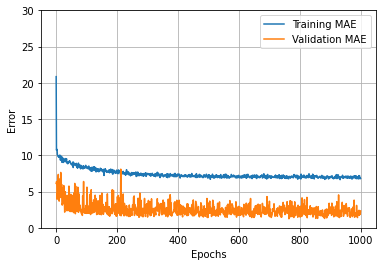

In [19]:
def plot_loss(history):
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.ylim([0, 30])
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

### Analyzing predictions generated from X_test against actual values (y_test)

31/31 [==============================] - 0s 483us/step


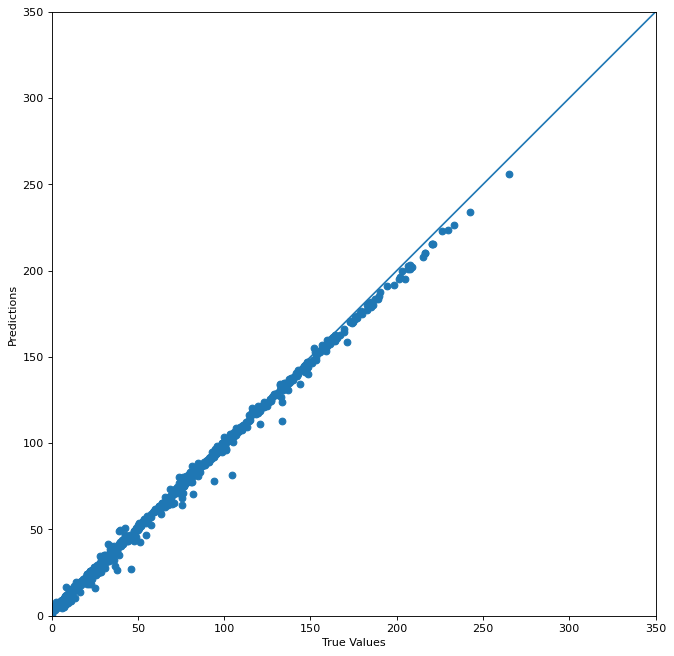

In [20]:
test_predictions = model.predict(X_test).flatten()

fig = plt.figure(figsize=(10,10), dpi = 80)

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('Actual values')
plt.ylabel('Preds')
ran = [0, 350]
plt.xlim(ran)
plt.ylim(ran)
_ = plt.plot(ran, ran)

In [21]:
# Create a dataframe to examine the details from actual values VS our predictions

checkdf = pd.DataFrame()
checkdf['actual'] = y_test
checkdf['prediction'] = test_predictions
checkdf['diff'] = checkdf['actual'] - checkdf['prediction']
checkdf.describe()

,actual,prediction,diff
count,984.000000,984.000000,984.000000
mean,57.042215,57.601940,-0.559714
std,55.248164,53.190464,3.087043
min,-0.800000,-0.377258,-10.551311
25%,10.600000,12.901734,-2.591283
50%,39.150000,41.385223,-1.495078
75%,90.550000,89.083927,0.932948
max,265.000000,255.948395,22.769867


In [22]:
checkdf.head(5)

,actual,prediction,diff
1835,203.0,199.564133,3.435867
1490,120.1,118.750259,1.349741
2065,9.0,11.157925,-2.157925
1178,44.6,45.879414,-1.279414
4055,50.6,51.127998,-0.527998


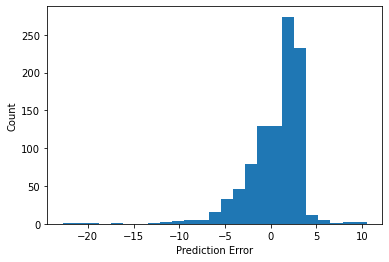

In [23]:
# Distribution of the errors margin. Pretty much standardized around 0 (normal curve)

margin = test_predictions - y_test
plt.hist(margin, bins=25)
plt.xlabel('Test predictions error margin')
_ = plt.ylabel('Count')

### Using the latest player stats (2021-2022 season) as our validation set and to predict next season's top performers

In [24]:
X_2021 = df_wr[df_wr['season'] == 2021]
y_2021 = X_2021['fantasy_points']
X_test2021 = X_2021.drop(columns=['player_id','position','name','fantasy_points'])

X_test2021 = StandardScaler().fit_transform(X_test2021)

val_predz = model.predict(X_test2021).flatten()
X_2021['predicted_points'] = val_predz
X_2021 = X_2021.sort_values(by=['predicted_points'],ascending=False)

8/8 [==============================] - 0s 566us/step


In [25]:
results = X_2021[['season','name','fantasy_points','predicted_points']]
results = results.reset_index(drop=True)
results

,season,name,fantasy_points,predicted_points
0,2021,Cooper Kupp,294.50,295.561676
1,2021,Justin Jefferson,222.40,228.069534
2,2021,Davante Adams,221.30,228.055832
3,2021,Ja'Marr Chase,223.60,227.931870
4,2021,Tyshun Samuel,261.96,224.951492
...,...,...,...,...
231,2021,Tyrie Cleveland,0.00,6.261990
232,2021,Devin Smith,0.00,6.113148
233,2021,David Moore,0.00,6.092426
234,2021,Geronimo Allison,0.00,6.071404


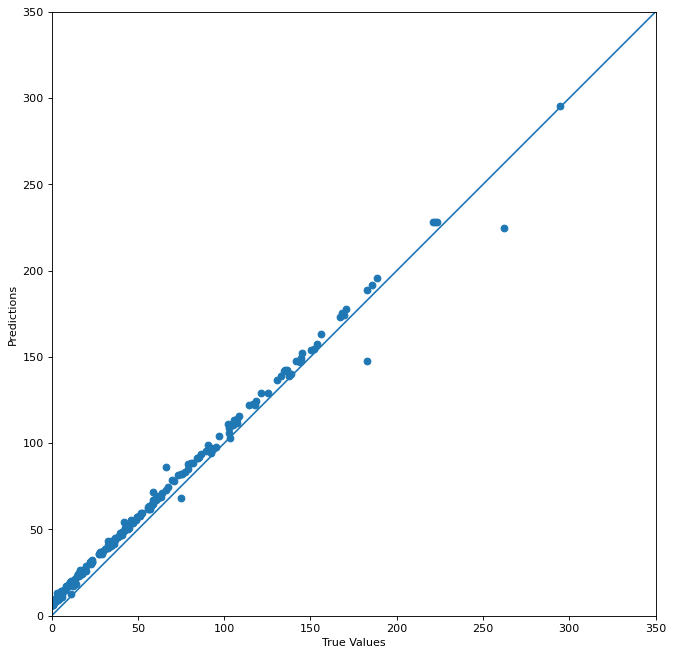

In [26]:
# Looks of our model against the 2021 data. Still very good prediction value overall

fig = plt.figure(figsize=(10,10), dpi = 80)

a = plt.axes(aspect='equal')
plt.scatter(y_2021, val_predz)
plt.xlabel('Actual values')
plt.ylabel('Preds')
ran = [0, 350]
plt.xlim(ran)
plt.ylim(ran)
_ = plt.plot(ran, ran)

In [27]:
# Create a dataframe to examine the details from actual values VS our predictions

df2021 = pd.DataFrame()

y_2021 = y_2021.reset_index(drop=True)

df2021['actual'] = y_2021
df2021['prediction'] = val_predz
df2021['diff'] = df2021['actual'] - df2021['prediction']
df2021.describe()

,actual,prediction,diff
count,236.000000,236.000000,236.000000
mean,51.486441,57.997303,-6.510877
std,56.449660,54.830276,4.439324
min,-1.200000,6.043747,-19.874234
25%,5.850000,12.902302,-7.833783
50%,34.450000,41.825825,-7.006871
75%,77.750000,85.183849,-6.239287
max,294.500000,295.561676,37.008508


In [28]:
df2021.head(5)

,actual,prediction,diff
0,44.8,50.587372,-5.787372
1,55.8,61.910183,-6.110183
2,89.7,95.408615,-5.708615
3,11.4,12.833881,-1.433881
4,79.1,87.847000,-8.747000


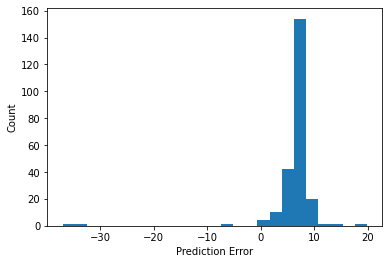

In [29]:
# A little higher error margin which was to be expected for future year values. Still more than acceptable results

margin = val_predz - y_2021.values
plt.hist(margin, bins=25)
plt.xlabel('Test predictions error margin')
_ = plt.ylabel('Count')

### What about these outliers? Difference > | 15 |

In [43]:
outliers = df2021[(df2021['diff'] > 15) | (df2021['diff'] < -15)]
results.iloc[[4, 18, 58]]

# Cordarrelle Patterson
# Jalen Guyton
# Tyshun Samuel

,season,name,fantasy_points,predicted_points
4,2021,Tyshun Samuel,261.96,224.951492
18,2021,Cordarrelle Patterson,182.60,147.902802
58,2021,Jalen Guyton,66.20,86.074234


#### Tyshun (Deebo) Samuel and Cordarrelle Patterson are both hybrids (only two WR in the NFL) who play RB, WR
#### Jalen Guyton was a rookie last year, breakout season I don't blame the model

### Let's compare my results against one of the most popular fantasy football resource available (what I usually use to make my picks every year!)

In [28]:
# Generating my official draft order (based on predictions)

draft = results[['name','predicted_points']]

draft.to_csv("C:/Users/phili/OneDrive/Desktop/draft.txt")

#### Comparing my 2022 draft VS the best in the business

https://www.fantasypros.com/nfl/rankings/wr-cheatsheets.php
    
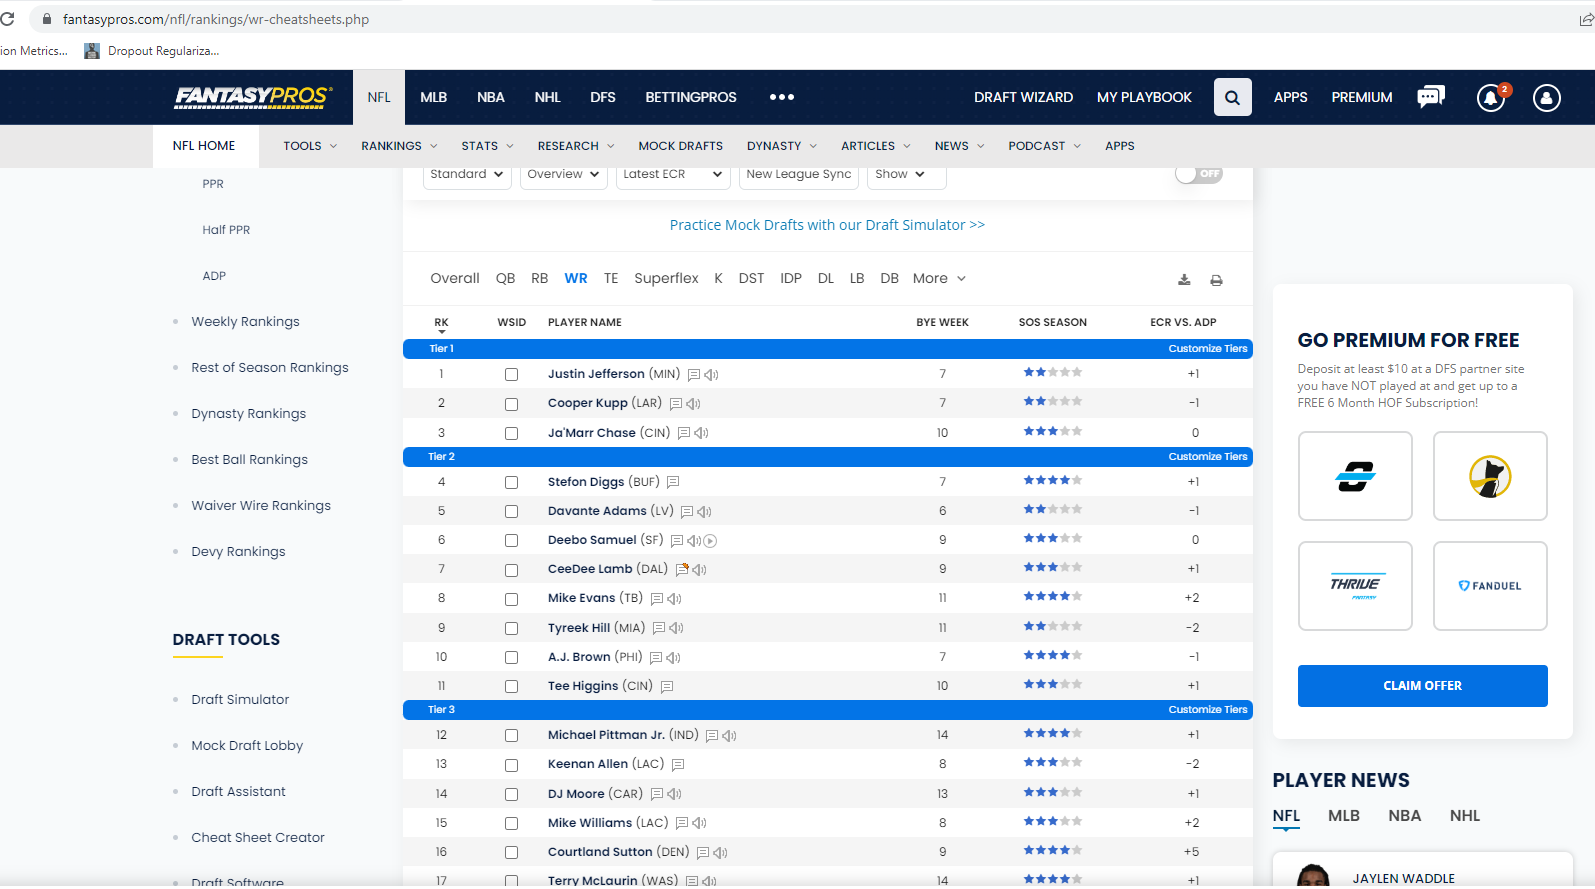

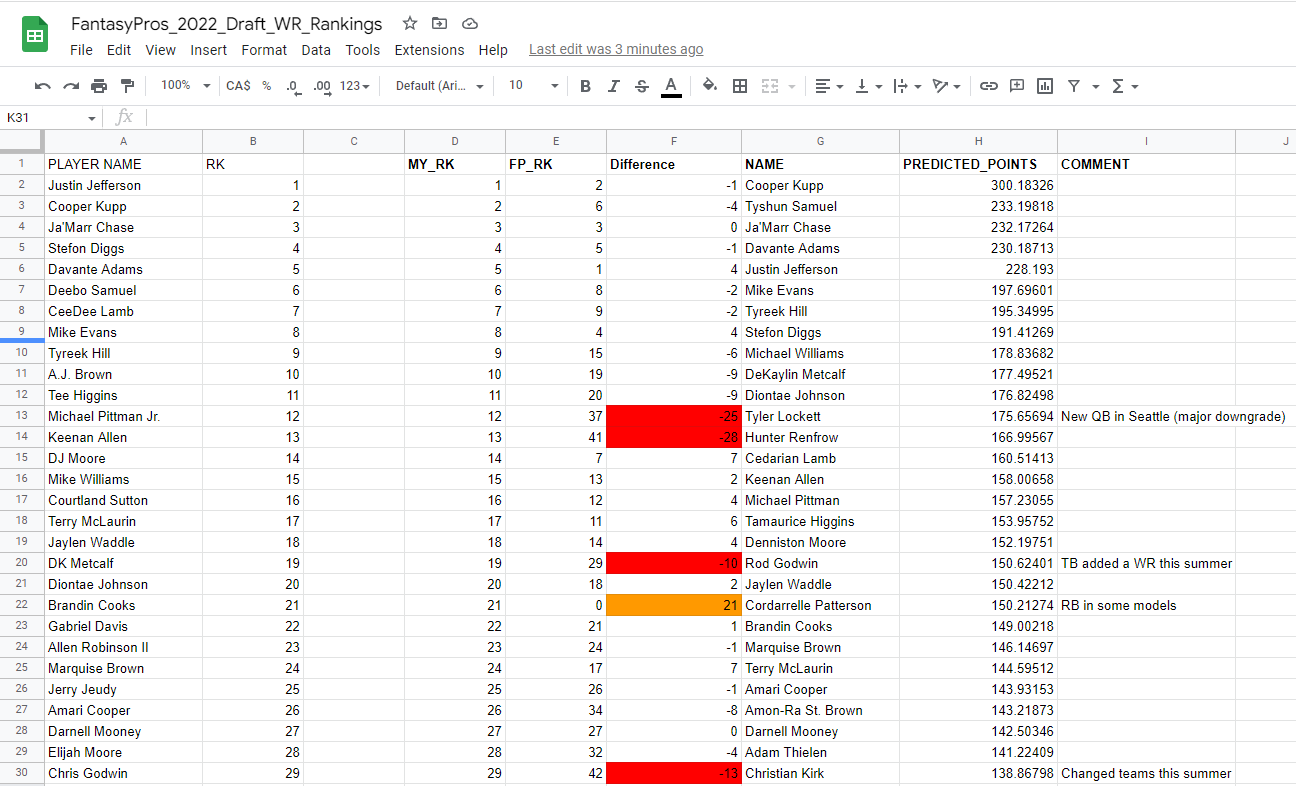


# Neural network vs classical regression, why?

While trying to optimize my neural network to yield the most precise predictions possible, I've been encountering a lot of articles/blogs that questioned the use of neural networks when trying to solve a problem that required regression. In the following blocks of code, I'll be comparing my neural network results to ones generate with linear regression (SKLEARN).

## Linear regression using SKLEARN

In [44]:
# Creating the linear regression model

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [-8.70898236e-02  1.31675238e-02  2.38617942e-01  2.06479404e-01
  4.13044456e-01  3.51739770e-02 -4.11101742e-02  1.37527900e-01
 -9.62331426e-01  3.95981845e+00  1.54417916e+00 -2.53468200e-02
 -4.22816293e-01  5.07686102e-01 -2.61270658e-01  4.72947643e-02
 -1.51390312e+00  6.03517265e-01  3.89836077e+01  1.81041491e+01
 -1.55470738e-02 -9.31402734e-01 -1.25323868e-01  2.11923679e-01
  3.31609509e-01  9.26362584e-02  5.61725571e-01 -1.73194792e-14
  1.24344979e-14 -1.15463195e-14  1.06581410e-14  7.10542736e-15
  4.30032035e-01 -4.11042066e-01  5.75758860e-01  2.62496003e-02
 -6.13936415e-01 -2.47372354e+00 -1.69655629e-01  3.61687807e+00
 -4.64521726e+00 -8.41620212e-03  1.29839789e-01  4.32266846e-01
  3.52121190e+00 -7.98678671e-02]
Mean squared error: 3.95
Coefficient of determination: 1.00


In [45]:
## Comparing MSE, MAE

score = model.evaluate(X_test, y_test)
print("")
print("Mean square error from neural net", score[2])
print("Mean absolute error from neural net", score[1])

print("")
mse_lr = mean_squared_error(y_test,y_pred)
mae_lr = mean_absolute_error(y_test,y_pred)
print("Mean square error from linear regression", mse_lr)
print("Mean absolute error from linear regression", mae_lr)

31/31 [==============================] - 0s 545us/step - loss: 9.8334 - mae: 2.4140 - mse: 9.8334

Mean square error from neural net 9.833428382873535
Mean absolute error from neural net 2.4139630794525146

Mean square error from linear regression 3.946164135337664
Mean absolute error from linear regression 0.9512263450289875


Mean squared error (MSE) (tf.keras.losses.MeanSquaredError) and mean absolute error (MAE) (tf.keras.losses.MeanAbsoluteError) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.

Similarly, evaluation metrics used for regression differ from classification.

When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.

Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the Overfit and underfit tutorial for more help with this.

Neural network VS regression:
    - It's hard to understand exactly why the NN worked. Why it's producing quality outputs and why you should trust it
    - On the otherhand, regression is fairly simple to understand. In my case, it produced an equation with an
      R2 of 1.00 which is perfect. So, we were able to find a perfect solution to the problem at hand. Looking at the 
      coefficients though, to try and understand which values had the highest importance in the analysis we can
      conclude that it doesn't make too much sense. It's okay in this case but I would rather trust our NN with 
      predictions.


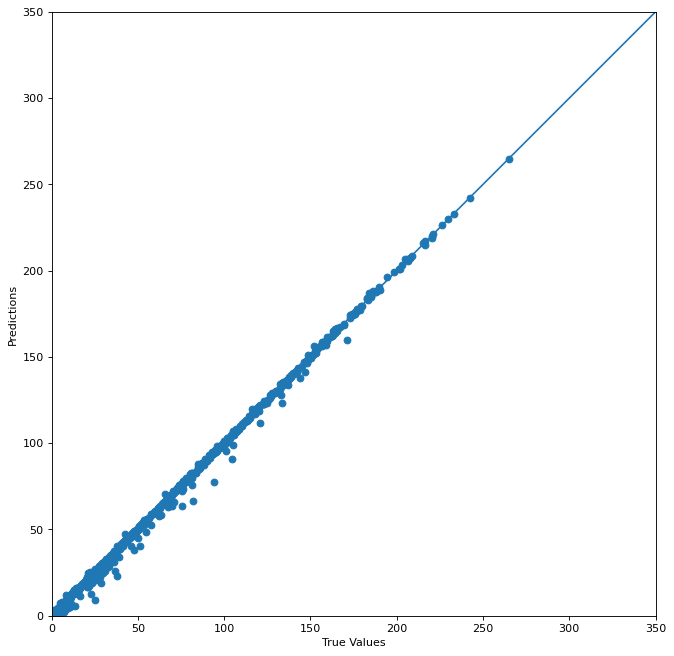

In [46]:
fig = plt.figure(figsize=(10,10), dpi = 80)

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Preds')
ran = [0, 350]
plt.xlim(ran)
plt.ylim(ran)
_ = plt.plot(ran, ran)

In [47]:
# Create a dataframe to examine the details from actual values VS our predictions

y_pred_reg = regr.predict(X_test2021)

dfreg = pd.DataFrame()

dfreg['actual'] = y_2021
dfreg['prediction'] = y_pred_reg 
dfreg['diff'] = dfreg['actual'] - dfreg['prediction']

print(dfreg.describe())

df2021.describe()

           actual  prediction        diff
count  236.000000  236.000000  236.000000
mean    51.486441   57.469820   -5.983379
std     56.449660   56.522883    3.569271
min     -1.200000    4.133025  -12.965562
25%      5.850000   11.301174   -6.983766
50%     34.450000   40.489475   -6.141049
75%     77.750000   83.574307   -5.602126
max    294.500000  307.465562   27.604964


,actual,prediction,diff
count,236.000000,236.000000,236.000000
mean,51.486441,57.997303,-6.510877
std,56.449660,54.830276,4.439324
min,-1.200000,6.043747,-19.874234
25%,5.850000,12.902302,-7.833783
50%,34.450000,41.825825,-7.006871
75%,77.750000,85.183849,-6.239287
max,294.500000,295.561676,37.008508


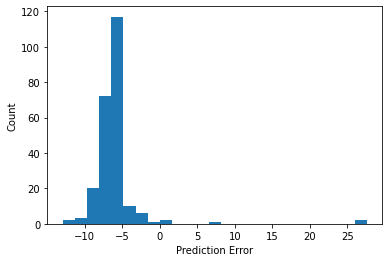

In [48]:
# Distribution of errors

margin = y_2021.values - y_pred_reg
plt.hist(margin, bins=25)
plt.xlabel('Test predictions error margin')
_ = plt.ylabel('Count')

## Deeper look at the coefficients

In [49]:
cols = list(X_2021.columns)
dropz = ['player_id','position','name','fantasy_points']

for i in dropz:
    cols.remove(i)
    
# Receiving yards and receiving TDs okay, highly positive valuation
# Target share, air yards shares should have highly positive valuation as well

for i,j in zip(cols, regr.coef_):
    print(i,j)

season -0.08708982364221474
completions 0.01316752376071259
attempts 0.23861794205904646
passing_yards 0.20647940364011322
passing_tds 0.4130444560978811
passing_air_yards 0.035173976992416825
passing_yards_after_catch -0.04111017424787083
passing_2pt_conversions 0.13752789969257959
carries -0.9623314258366447
rushing_yards 3.9598184514717327
rushing_tds 1.5441791587633578
rushing_fumbles -0.02534681999008623
rushing_fumbles_lost -0.42281629282714844
rushing_first_downs 0.5076861019011365
rushing_epa -0.2612706576292647
rushing_2pt_conversions 0.04729476425406851
receptions -1.513903116307714
targets 0.6035172645619392
receiving_yards 38.98360772283484
receiving_tds 18.104149147320477
receiving_fumbles -0.015547073752647467
receiving_fumbles_lost -0.9314027336872079
receiving_air_yards -0.1253238682764217
receiving_yards_after_catch 0.21192367866778944
receiving_first_downs 0.33160950930951283
receiving_epa 0.09263625841985346
receiving_2pt_conversions 0.5617255711645123
pacr -1.731947

### That doesn't seem right...

- carries -0.9623314258366447
- rushing_tds 1.5441791587633578
- receptions -1.513903116307714
- targets 0.6035172645619392
- receiving_yards 38.98360772283484
- receiving_tds 18.104149147320477
- target_share -1.1546319456101628e-14 (0)
- air_yards_share 1.0658141036401503e-14 (0)

### Why stick with the neural network

This tells me that the regression model incorrectly assigns "importance" to some of our features. Yes, the R2 is equal to one, so the computer was able explain all of the variation (loss) between our actual and predicted values. That doesn't mean the model is more robust than the neural network. Looking at the values assigned to various coefficients helps to put perspective into the results.

# Deployment (Demo)

#### Step #1 : Save the model to an H5 file. 
This way we will be then able to load it from the tf.keraas.models.load_model() method

In [50]:
path = 'C:/Users/phili/OneDrive/Desktop/DataScience/ds-final-project/FF_model.h5'
model.save(path)

INFO:tensorflow:Assets written to: ram://3641e8b4-c695-40f2-86f6-13521003e617/assets


#### Step #2 : Generate the input that will be passed to our model to generate predictions

In [ ]:
X_deploy = df_wr[df_wr['season'] == 2021]
X_deploy = X_deploy.drop(columns=['player_id','position','name','fantasy_points'])
X_deploy.to_csv("C:/Users/phili/OneDrive/Desktop/deploy.csv")

Since my model takes 46 features, and usually will have a minimum of 200-300 rows it wasn't effecient to pass the data as a text or an array from the APP.

Much easier to pass a CSV file with the input data -->

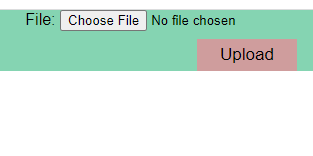

#### Step #3 : Load the input data in the app and check the results!

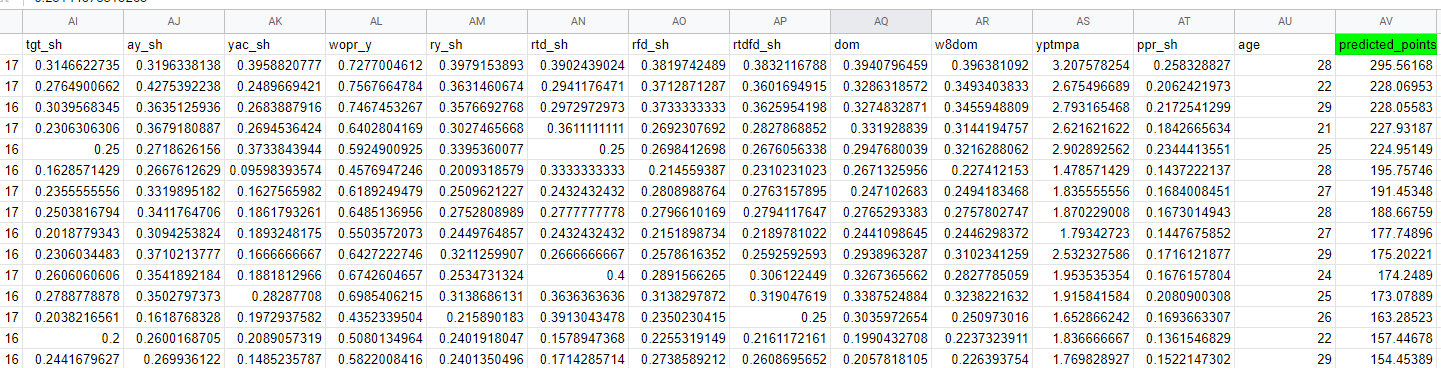

Actual deployment code can be found in the flask_deployment.py file

# Conclusion

Although I am extremely happy with the my prediction results (already used my model to make the picks for my 2022 team), I think there is still room to improve my neural network. Here are a few things I think could make it even more reliable :

- Add a features that measure the current strenght of a specific WR :
    - Schedule (playing against strong or weak opponents)
    - Quality of QB
    - Injury history
- Pull weekly data during the season to see how the model performs on a weekly basis instead of yearly
- Keep iterating with model configuration (number of neurons, layers, activation functions)